# Исследование пользователей сервиса аренды самокатов

В рамках данного исследования планируется выполнить следующие этапы:
1. Загрузить и предобработать данные о пользователях, подписках и поездах сервиса GoFast
2. Проанализировать и визуализировать информацию о пользователях и поездках
3. Объединить данные в новые датафреймы
4. Рассчитать суммарные расстояние, количество поездок, суммарное время и суммарную выручку
5. Проверить гипотезы, чтобы выяснить насколько целесообразны акции, которые собираются проводить продакт-менеджеры

Исследование проводится, чтобы помочь продакт-менеджерам принять решение о проведении акций для увеличения количества пользователей с подпиской. Необходимо выяснить насколько различаются показатели между пользователями с подпиской и без нее.


In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
def check_df (df):

    display(df.info())

    display(df.head())

In [4]:
check_df(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
check_df(rides)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


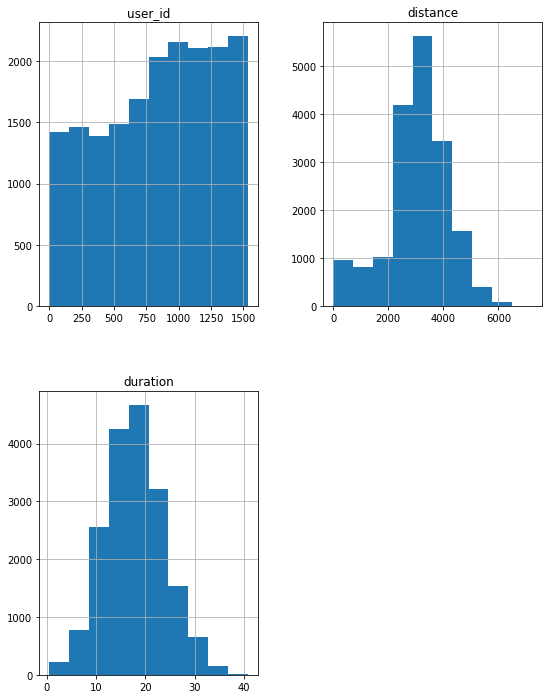

In [6]:
rides.hist(figsize=(9,12))
plt.show()

In [7]:
check_df(subscriptions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Из общей информации по имеющимся данным можно сказать, что с первого взгляда особых проблем не видно. Тип данных в столбце date не соответствует необходимому datetime.  

#### Шаг 2. Предобработка данных

In [8]:
# Изменим тип данных в столбце date датафрейма rides
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [9]:
users.duplicated().sum()

31

In [10]:
# Очистим таблицу users от дубликатов
users = users.drop_duplicates().reset_index(drop=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


In [11]:
rides.duplicated().sum()

0

In [12]:
# Добавим столбец с месяцем, в который была совершена поездка
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [13]:
# Округлим данные в столбцах distance и duration до целых и одного знака после запятой соответственно
rides['distance'] = rides['distance'].round(0)
rides['distance'] = rides['distance'].astype(dtype='int')
rides['duration'] = rides['duration'].round(1)
rides.head(10)

,user_id,distance,duration,date,month
0,1,4410,25.6,2021-01-01,1
1,1,2618,15.8,2021-01-18,1
2,1,754,6.2,2021-04-20,4
3,1,2695,18.5,2021-08-11,8
4,1,4029,26.3,2021-08-28,8
5,1,2771,16.7,2021-10-09,10
6,1,3039,14.9,2021-10-19,10
7,1,2842,23.1,2021-11-06,11
8,1,3413,15.2,2021-11-14,11
9,1,749,15.0,2021-11-22,11


In [14]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [15]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Пропущенных значений в данных не обнаружено, найденные дубликаты в таблице users были удалены. 

#### Шаг 3. Исследовательский анализ данных

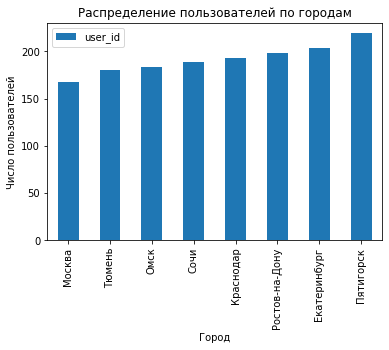

In [16]:
users_city = users.pivot_table(values='user_id', index='city', aggfunc='count')
users_city = users_city.sort_values(by='user_id',ascending=True)
users_city.plot(kind='bar')
plt.title('Распределение пользователей по городам')
plt.xlabel('Город')
plt.ylabel('Число пользователей')

plt.show()

In [17]:
display(users_city)

,user_id
city,
Москва,168
Тюмень,180
Омск,183
Сочи,189
Краснодар,193
Ростов-на-Дону,198
Екатеринбург,204
Пятигорск,219


Как можно заметить на графике, сервис действует в 8 городах. Наибольшее количество пользователей в Пятигорске (219), наименьшее в Москве (168), В остальном отрыв по количеству пользователей между городами не так велик.

,user_id
subscription_type,
free,835
ultra,699


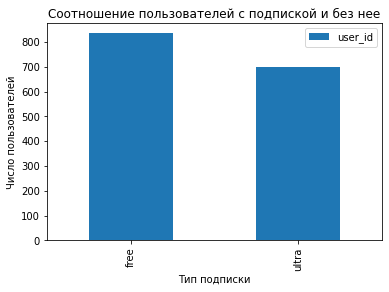

In [18]:
users_sub = users.pivot_table(values='user_id', index='subscription_type', aggfunc='count')
display(users_sub)
users_sub.plot(kind='bar')
plt.title('Соотношение пользователей с подпиской и без нее')
plt.xlabel('Тип подписки')
plt.ylabel('Число пользователей')

plt.show()

In [19]:
users_free = users.loc[users['subscription_type'] == "free", 'user_id'].count()
users_ultra = users.loc[users['subscription_type'] == "ultra", 'user_id'].count()
print('Процент пользователей без подписки составляет:', "{:.0%}".format(users_free / (users_free + users_ultra)))
print('Процент пользователей с подпиской составляет:', "{:.0%}".format(users_ultra / (users_free + users_ultra)))

Процент пользователей без подписки составляет: 54%
Процент пользователей с подпиской составляет: 46%


В общем количестве пользователей разница между количеством пользователей с подпиской и без нее составляет 8%. Это достаточно хороший результат, видимо, подписка действительно выгодна пользователям.

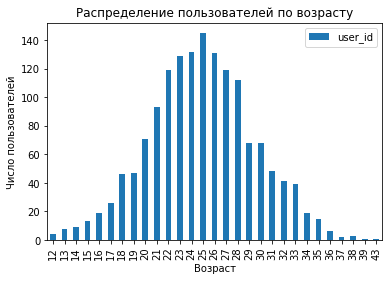

In [20]:
users_age = users.pivot_table(values='user_id', index='age', aggfunc='count')
users_age.plot(kind='bar')
plt.title('Распределение пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Число пользователей')

plt.show()

In [21]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Распределение возраста близко к нормальному, можно заметить, что среднее и медиана практически равны и приходятся на 25 лет.

In [22]:
print('Среднее расстояние преодоленное за одну поездку:', rides['distance'].mean())
print('Медианное расстояние преодоленное за одну поездку:', rides['distance'].median())

Среднее расстояние преодоленное за одну поездку: 3070.659010405136
Медианное расстояние преодоленное за одну поездку: 3134.0


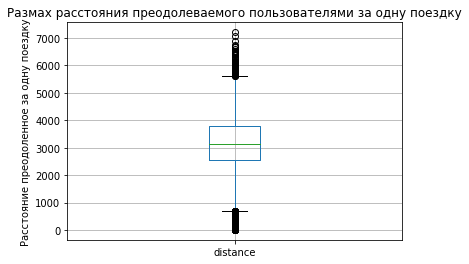

In [23]:
rides.boxplot(column=['distance'])
plt.title('Размах расстояния преодолеваемого пользователями за одну поездку')
plt.ylabel('Расстояние преодоленное за одну поездку')

plt.show()

In [24]:
print('Среднее время одной поездки:', rides['duration'].mean())
print('Медианное время одной поездки:', rides['duration'].median())

Среднее время одной поездки: 17.804920301084792
Медианное время одной поездки: 17.7


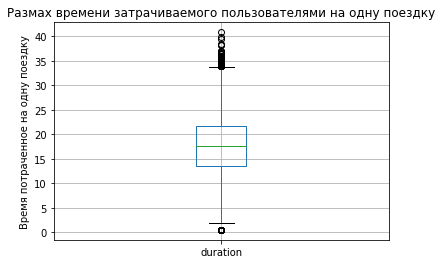

In [25]:
rides.boxplot(column=['duration'])
plt.title('Размах времени затрачиваемого пользователями на одну поездку')
plt.ylabel('Время потраченное на одну поездку')

plt.show()

Распределение пользователей по городам приблизительно равное, наименьшее число пользователей в Москве (168 человек), а наибольшее в Пятигорске (219 человек). Процент пользователей без подписки составил 54% (835 человек), а пользователей с подпиской - 46% (699 человек).

Медианное расстояние, преодоленное за одну поездку составляет 3134 метра, по диаграмме видно, что много поездок составляют менее 800 метров, эти значения тянут вниз среднее, которое оказалось меньше медианы. По длительности поездки среднее и медиана почти сравнялись и равны 17,7-17,8 минут.

#### Шаг 4. Объединение данных

In [26]:
# Создадим методом merge() объединенный датафрейм
users_and_rides = users.merge(
    rides,
    on='user_id',
    how='inner')

In [27]:
data_merge = users_and_rides.merge(
    subscriptions,
    on='subscription_type',
    how='inner')
display(data_merge)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410,25.6,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618,15.8,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754,6.2,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695,18.5,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029,26.3,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781,19.8,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840,21.4,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826,18.4,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902,16.7,2021-11-27,11,8,50,0


In [28]:
# Создадим отдельно таблицы для пользователей с подпиской и без нее
data_sub_ultra = data_merge.query('subscription_type == "ultra"')

data_sub_free = data_merge.query('subscription_type == "free"')

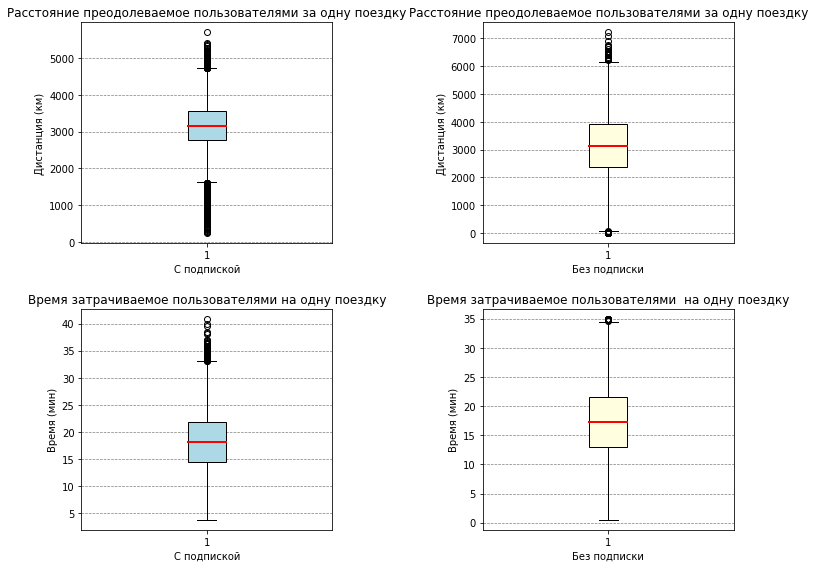

In [29]:
# Построим диаграммы размаха для созданных таблиц по столбцам duration и distance
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

colors = ['lightblue', 'lightyellow']
# Диаграмма размаха 1: Размах расстояния преодолеваемого пользователями (с подпиской) за одну поездку
axs[0, 0].boxplot(data_sub_ultra['distance'], patch_artist=True,
                  boxprops=dict(facecolor=colors[0]),
                  medianprops=dict(color='red', linewidth=2))
axs[0, 0].set_title('Расстояние преодолеваемое пользователями за одну поездку')
axs[0, 0].set_xlabel('С подпиской')
axs[0, 0].set_ylabel('Дистанция (км)')
axs[0, 0].grid(True, axis='y', linestyle='--', color='grey', linewidth=0.7)

# Диаграмма размаха 2: Размах расстояния преодолеваемого пользователями (без подписки) за одну поездку
axs[0, 1].boxplot(data_sub_free['distance'], patch_artist=True, 
                 boxprops=dict(facecolor=colors[1]),
                 medianprops=dict(color='red', linewidth=2))
axs[0, 1].set_title('Расстояние преодолеваемое пользователями за одну поездку')
axs[0, 1].set_xlabel('Без подписки')
axs[0, 1].set_ylabel('Дистанция (км)')
axs[0, 1].grid(True, axis='y', linestyle='--', color='grey', linewidth=0.7)

# Диаграмма размаха 3: Среднее время с подпиской
axs[1, 0].boxplot(data_sub_ultra['duration'], patch_artist=True,
                  boxprops=dict(facecolor=colors[0]),
                  medianprops=dict(color='red', linewidth=2))
axs[1, 0].set_title('Время затрачиваемое пользователями на одну поездку')
axs[1, 0].set_xlabel('С подпиской')
axs[1, 0].set_ylabel('Время (мин)')
axs[1, 0].grid(True, axis='y', linestyle='--', color='grey', linewidth=0.7)

# Диаграмма размаха 4: Среднее время без подписки
axs[1, 1].boxplot(data_sub_free['duration'], patch_artist=True,
                  boxprops=dict(facecolor=colors[1]),
                  medianprops=dict(color='red', linewidth=2))
axs[1, 1].set_title('Время затрачиваемое пользователями  на одну поездку')
axs[1, 1].set_xlabel('Без подписки')
axs[1, 1].set_ylabel('Время (мин)')
axs[1, 1].grid(True, axis='y', linestyle='--', color='grey', linewidth=0.7)

# Оформление пространства между графиками
plt.tight_layout()
plt.subplots_adjust(wspace=0.6, hspace=0.3)
# Показ графиков
plt.show()

In [30]:
# Создадим отдельный датафрейма для построения гистограмм
distance_and_duration = pd.DataFrame(columns=['distance_ultra', 'distance_free', 'duration_ultra', 'duration_free'])
distance_and_duration['distance_ultra'] = data_sub_ultra['distance']
distance_and_duration['duration_ultra'] = data_sub_ultra['duration']

In [31]:
data_sub_free = data_sub_free.reset_index(drop=True)
distance_and_duration['distance_free'] = data_sub_free['distance']
distance_and_duration['duration_free'] = data_sub_free['duration']

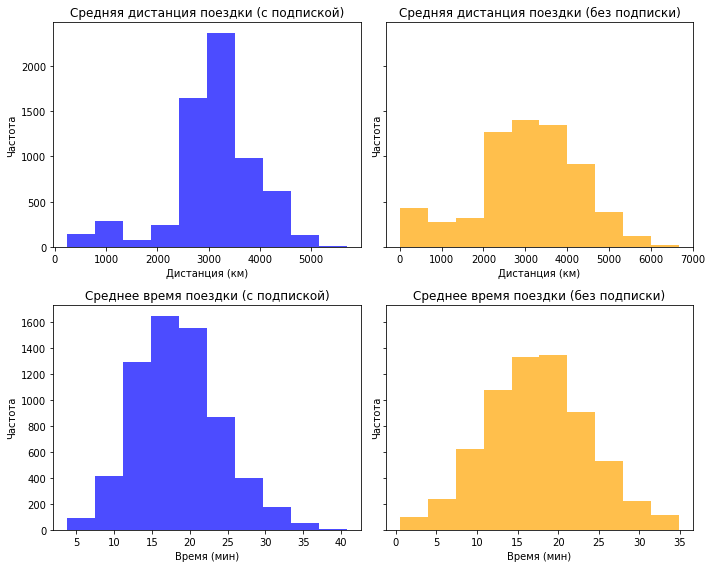

In [32]:
# Построим гистограммы для созданного датафрейма
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey='row')

# Гистограмма 1: Средняя дистанция с подпиской
axs[0, 0].hist(distance_and_duration['distance_ultra'].dropna(), color='blue', alpha=0.7)
axs[0, 0].set_title('Средняя дистанция поездки (с подпиской)')
axs[0, 0].set_xlabel('Дистанция (км)')
axs[0, 0].set_ylabel('Частота')

# Гистограмма 2: Средняя дистанция без подписки
axs[0, 1].hist(distance_and_duration['distance_free'].dropna(), color='orange', alpha=0.7)
axs[0, 1].set_title('Средняя дистанция поездки (без подписки)')
axs[0, 1].set_xlabel('Дистанция (км)')
axs[0, 1].set_ylabel('Частота')

# Гистограмма 3: Среднее время с подпиской
axs[1, 0].hist(distance_and_duration['duration_ultra'].dropna(), color='blue', alpha=0.7)
axs[1, 0].set_title('Среднее время поездки (с подпиской)')
axs[1, 0].set_xlabel('Время (мин)')
axs[1, 0].set_ylabel('Частота')

# Гистограмма 4: Среднее время без подписки
axs[1, 1].hist(distance_and_duration['duration_free'].dropna(), color='orange', alpha=0.7)
axs[1, 1].set_title('Среднее время поездки (без подписки)')
axs[1, 1].set_xlabel('Время (мин)')
axs[1, 1].set_ylabel('Частота')

# Оформление пространства между графиками
plt.tight_layout()

# Показ графиков
plt.show()

Обратив внимание на диаграммы, видно, что несмотря на примерно равную медиану (около 3100 метров) люди с подпиской совершают более однородные поездки, межквартильный размах на диаграмме для них меньше. Также у пользователей с подпиской больше поездок дольше 25 минут, возможно, с подпиской действительно дешевле совершать долгие поездки.

Проанализировав диаграммы, видно, что пользователи без подписки чаще совершают поездки менее 2 километров, в свою очередь у пользователей с подпиской ярко выраженный пик в области от 3 до 3,5 километров.

#### Шаг 5. Подсчёт выручки

In [34]:
data_merge['duration'] = np.ceil(data_merge['duration'])
data_pivot = data_merge.pivot_table(
    values=('distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee'),
    index=('user_id', 'month'),
    aggfunc=('sum', 'count'))
data_pivot.head(5)

distance       duration       minute_price     start_ride_price  \
                 count   sum    count   sum        count sum            count   
user_id month                                                                   
1       1            2  7028        2  42.0            2  12                2   
        4            1   754        1   7.0            1   6                1   
        8            2  6724        2  46.0            2  12                2   
        10           2  5810        2  32.0            2  12                2   
        11           3  7004        3  55.0            3  18                3   

                  subscription_fee       
              sum            count  sum  
user_id month                            
1       1       0                2  398  
        4       0                1  199  
        8       0                2  398  
        10      0                2  398  
        11      0                3  597

In [35]:
data_pivot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (1534, 12)
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   (distance, count)          11331 non-null  int64  
 1   (distance, sum)            11331 non-null  int64  
 2   (duration, count)          11331 non-null  int64  
 3   (duration, sum)            11331 non-null  float64
 4   (minute_price, count)      11331 non-null  int64  
 5   (minute_price, sum)        11331 non-null  int64  
 6   (start_ride_price, count)  11331 non-null  int64  
 7   (start_ride_price, sum)    11331 non-null  int64  
 8   (subscription_fee, count)  11331 non-null  int64  
 9   (subscription_fee, sum)    11331 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 930.6 KB


In [36]:
# Переименуем столбцы, удалим ненужные повторяющиеся столбцы, созданные функцией count
data_pivot.columns=[
    'number_of_rides', 'distance', 'number2', 'duration', 'number3', 
    'minute_price', 'number4', 'start_ride_price', 'number5', 'subscription_fee']
data_pivot = data_pivot.drop(['number2', 'number3', 'number4', 'number5'], axis=1)
data_pivot.head()

number_of_rides  distance  duration  minute_price  \
user_id month                                                      
1       1                    2      7028      42.0            12   
        4                    1       754       7.0             6   
        8                    2      6724      46.0            12   
        10                   2      5810      32.0            12   
        11                   3      7004      55.0            18   

               start_ride_price  subscription_fee  
user_id month                                      
1       1                     0               398  
        4                     0               199  
        8                     0               398  
        10                    0               398  
        11                    0               597

In [37]:
# Как мы знаем из условий поездки у пользователей с подпиской цена старта 0 рублей, а цена за минуту 6 рублей
# заменим значения в столбцах minute_price, start_ride_price и subscription_fee исходя из условий поездки
data_pivot.loc[data_pivot['start_ride_price'] == 0, 'minute_price'] = 6
data_pivot.loc[data_pivot['subscription_fee'] >= 199, 'subscription_fee'] = 199

In [38]:
data_pivot.loc[data_pivot['start_ride_price'] >= 50, 'start_ride_price'] = 50

In [39]:
data_pivot.loc[data_pivot['start_ride_price'] == 50, 'minute_price'] = 8

In [40]:
data_pivot.head(10)

number_of_rides  distance  duration  minute_price  \
user_id month                                                      
1       1                    2      7028      42.0             6   
        4                    1       754       7.0             6   
        8                    2      6724      46.0             6   
        10                   2      5810      32.0             6   
        11                   3      7004      55.0             6   
        12                   2      6752      28.0             6   
2       3                    3     10188      63.0             6   
        4                    2      6165      40.0             6   
        6                    1      3255      14.0             6   
        7                    2      6781      47.0             6   

               start_ride_price  subscription_fee  
user_id month                                      
1       1                     0               199  
        4                     0               199  
        8                     0               199  
        10                    0               199  
        11                    0               199  
        12                    0               199  
2       3                     0               199  
        4                     0               199  
        6                     0               199  
        7                     0               199

In [41]:
display(data_pivot['minute_price'].unique())
display(data_pivot['start_ride_price'].unique())

array([6, 8])

array([ 0, 50])

In [42]:
# Добавим столбец с выручкой от каждого пользователя за каждый месяц
def sum_revenue(row):
    if row['start_ride_price'] == 0:
        return (row['duration'] * row['minute_price'] + row['subscription_fee'])
    else:
        return (row['duration'] * row['minute_price'] + row['number_of_rides'] * row['start_ride_price'])

data_pivot['revenue'] = data_pivot.apply(sum_revenue, axis=1)
data_pivot.head(10)

number_of_rides  distance  duration  minute_price  \
user_id month                                                      
1       1                    2      7028      42.0             6   
        4                    1       754       7.0             6   
        8                    2      6724      46.0             6   
        10                   2      5810      32.0             6   
        11                   3      7004      55.0             6   
        12                   2      6752      28.0             6   
2       3                    3     10188      63.0             6   
        4                    2      6165      40.0             6   
        6                    1      3255      14.0             6   
        7                    2      6781      47.0             6   

               start_ride_price  subscription_fee  revenue  
user_id month                                               
1       1                     0               199    451.0  
        4                     0               199    241.0  
        8                     0               199    475.0  
        10                    0               199    391.0  
        11                    0               199    529.0  
        12                    0               199    367.0  
2       3                     0               199    577.0  
        4                     0               199    439.0  
        6                     0               199    283.0  
        7                     0               199    481.0

Подготовили таблицу с выручкой для дальнейшей проверки гипотез.

#### Шаг 6. Проверка гипотез

В рамках этого шага планируется проверить три гипотезы:
1. Тратят ли пользователи с подпиской больше времени на поездки? 
    1. H0 - время, которое тратят на поездку пользователи с подпиской равно времени, которое тратят пользователи без подписки;
    2. H1 - время, которое тратят на поездку пользователи с подпиской больше времени, которое тратят пользователи без подписки;
2. Можно ли сказать, что среднее расстояние, которое проезжают за одну поездку пользователи с подпиской не превышает 3130 метров?
    1. H0 - среднее расстояние равно 3130 метрам;
    2. Н1 - среднее расстояние больше 3130 метров;
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
    1. H0 - помесячная выручка от пользователей с подпиской равна или меньше выручки от пользователей без подписки;
    2. H1 - помесячная выручка от пользователей с подпиской больше выручки от пользователей без подписки.

In [43]:
# Тратят ли пользователи с подпиской больше времени на поездки?
alpha = 0.05
results1 = st.ttest_ind(data_sub_ultra['duration'], data_sub_free['duration'], alternative='greater')
print(results1.pvalue)
if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

1.3448182372889e-34
Отвергаем нулевую гипотезу


P-value оказалось настолько мало, что позволяет отвергнуть гипотезу о том, что люди с подпиской тратят столько же (меньше) времени, как и люди без подписки, в пользу гипотезы о том, что люди с подпиской тратят больше времени на поездки.

In [44]:
# Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
results2 = st.ttest_1samp(data_sub_ultra['distance'], 3130, alternative='greater')
print(results2.pvalue)
if results2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

0.9195649894697724
Не получилось отвергнуть нулевую гипотезу


Значение p-value составляет 0,91, таким образом вероятность, что расстояние преодоленное за поездку будет менее 3130 составляет 91%.

Это позволяет нам согласиться с тем, что среднее расстояние в большинстве поездок не превышает 3130 метров.

In [45]:
# Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
data_pivot_ultra = data_pivot.query('start_ride_price == 0')

data_pivot_free = data_pivot.query('start_ride_price == 50')

results3 = st.ttest_ind(data_pivot_ultra['revenue'], data_pivot_free['revenue'], alternative='greater')
print(results3.pvalue)
if results3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

5.015631474144602e-32
Отвергаем нулевую гипотезу


Данные позволяют отвергнуть гипотезу H0 в пользу гипотезы о том, что помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки. Даже если бы показатель alpha был равен 0.01, значение p-value было бы меньше, и гипотеза также была бы отвергнута. Получается продакт-менеджеры не зря концентрируют внимание на пользователях с подпиской.

#### Общий вывод

В ходе данного исследования были сделаны следующие выводы:
 1. Изначальные данные достаточно хорошие, пропусков не обнаружено, в таблице users были дубликаты около 2% от всех данных;
 2. В выборке людей без подписки на 19% больше, чем людей с подпиской;
 3. Медианное расстояние, преодоленное за одну поездку составляет 3134 метра. Медианная длительность одной поездки составляет почти 18 минут;
 4. У пользователей с подпиской больше поездок дольше 35 минут, возможно, с подпиской действительно дешевле совершать долгие поездки;
 5. После проверки гипотез мы отвергли гипотезу о том, что люди с подпиской тратят столько же (или меньше) времени на поездку, как и люди без подписки. Однако, данные не позволили отвергнуть гипотезы, что среднее расстояние поездки у людей с подпиской равно или меньше 3130 метрам. Также отвергли гипотезу о том, что помесячная выручка от пользователей с подпиской равна выручке от пользователей без подписки в пользу гипотезы о том, что выручка от пользователей с подпиской выше.

Таким образом, данные показывают, что у продакт-менеджеров есть все причины концентрировать свое внимание на пользователях с подпиской, они осуществляют более долгие поездки, при этом в большинстве поездок не превышая оптимального расстояния для одной поездки, и приносят больше выручки.